# Stage 4 Explore Stim & Violation Interactions

Goal: assess the variance of the previous violation regressor for ech animal and simulate psychometrics with varying filter strengths subject to each animal (e.g. median value). This will be only for animals in stage 4 and mostly trained. This notebook comes from explore_stim_viol_interxs.ipynb where it was run on the full dataset.

In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from violations_eda import *
from fitting_utils import create_violation_interaction_pairs
from get_rat_data import get_rat_viol_data
from experiment_sigma_sweep import ExperimentSigmaSweep
from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import ModelVisualizer
from design_matrix_generator import DesignMatrixGeneratorInteractions
from psychometrics import *
sns.set_context("talk")
%load_ext autoreload
%autoreload 2

results_path = "/Users/jessbreda/Desktop/github/animal-learning/data/results/"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
stg4_animals = [
    "W051",
    "W060",
    "W065",
    "W068",
    "W072",
    "W073",
    "W074",
    "W075",
    "W078",
    "W080",
    "W082",
    "W083",
    "W088",
    "W089",
]

## Part 1: Assess Distribution of Filtered Regressor

In [9]:
prev_violation_df = generate_design_mat_with_filter_viol_stg4(animal_ids=stg4_animals)

returning viol data for W051
returning viol data for W060
returning viol data for W065
returning viol data for W068
returning viol data for W072
returning viol data for W073
returning viol data for W074
returning viol data for W075
returning viol data for W078
returning viol data for W080
returning viol data for W082
returning viol data for W083
returning viol data for W088
returning viol data for W089


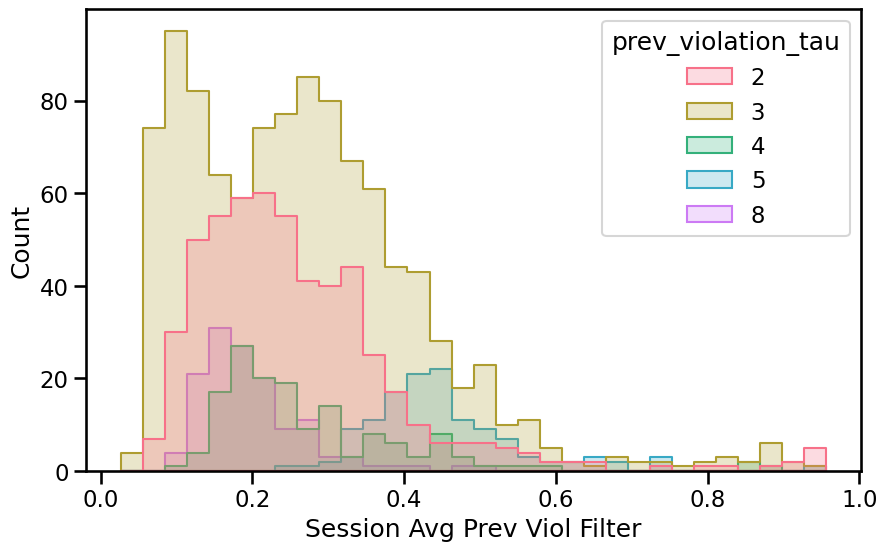

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(
    data=prev_violation_df.groupby(["animal_id", "session", "prev_violation_tau"])
    .prev_violation_exp.mean()
    .reset_index(),
    x="prev_violation_exp",
    hue="prev_violation_tau",
    palette=sns.color_palette("husl", 5),
    element="step",
    ax=ax,
)

_ = ax.set(xlabel="Session Avg Prev Viol Filter")

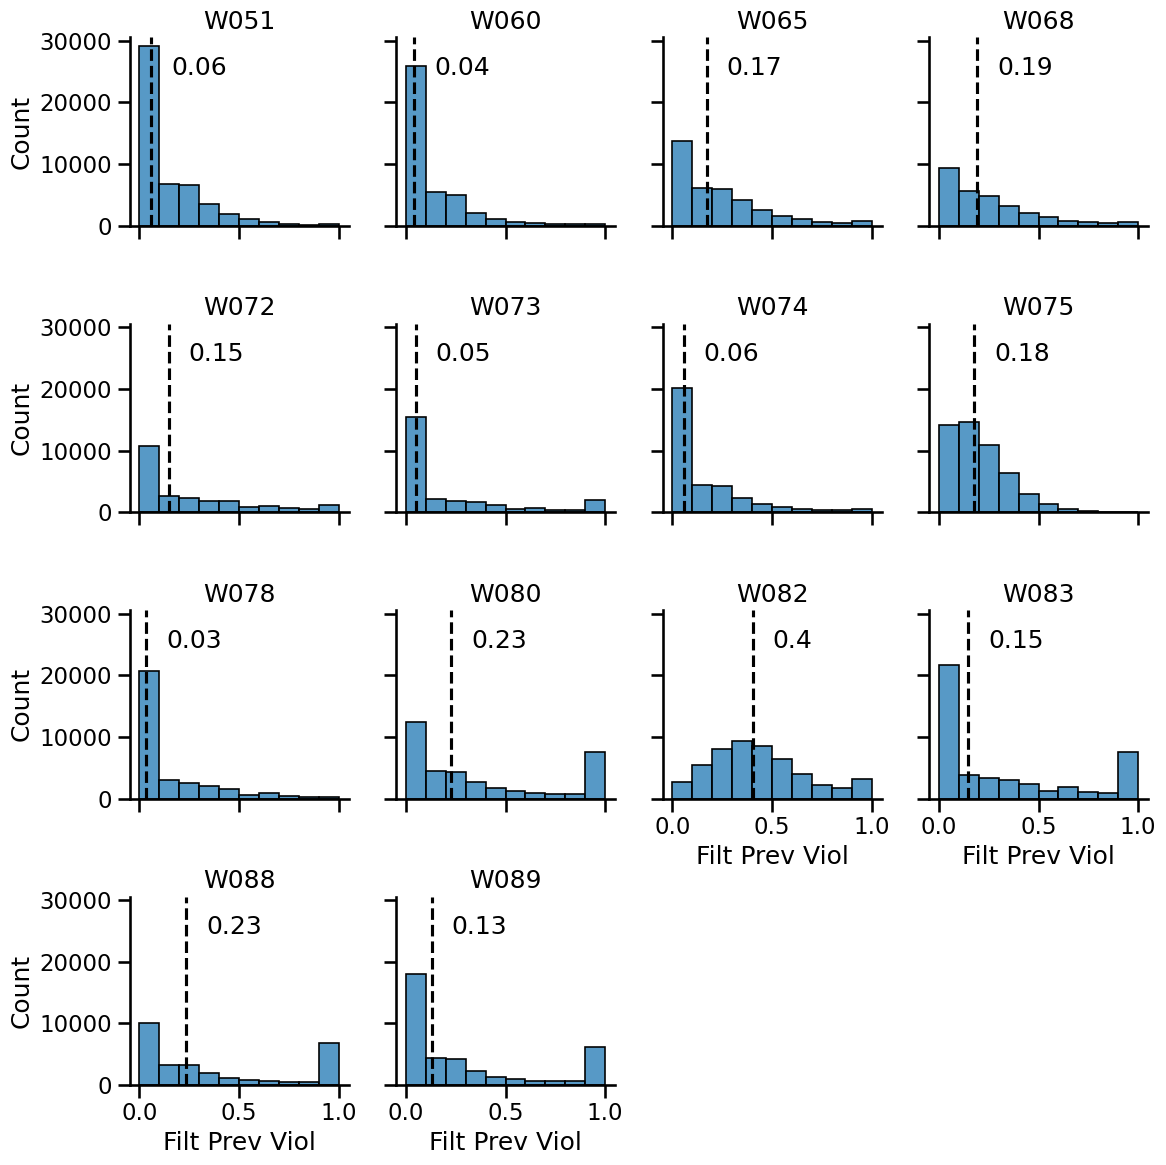

In [12]:
g = plot_histogram_facet_grid(prev_violation_df, "prev_violation_exp", binwidth=0.1)

g.map_dataframe(plot_prev_viol_median)
g.set_axis_labels("Filt Prev Viol", "Count")
g.set_titles("{col_name}")

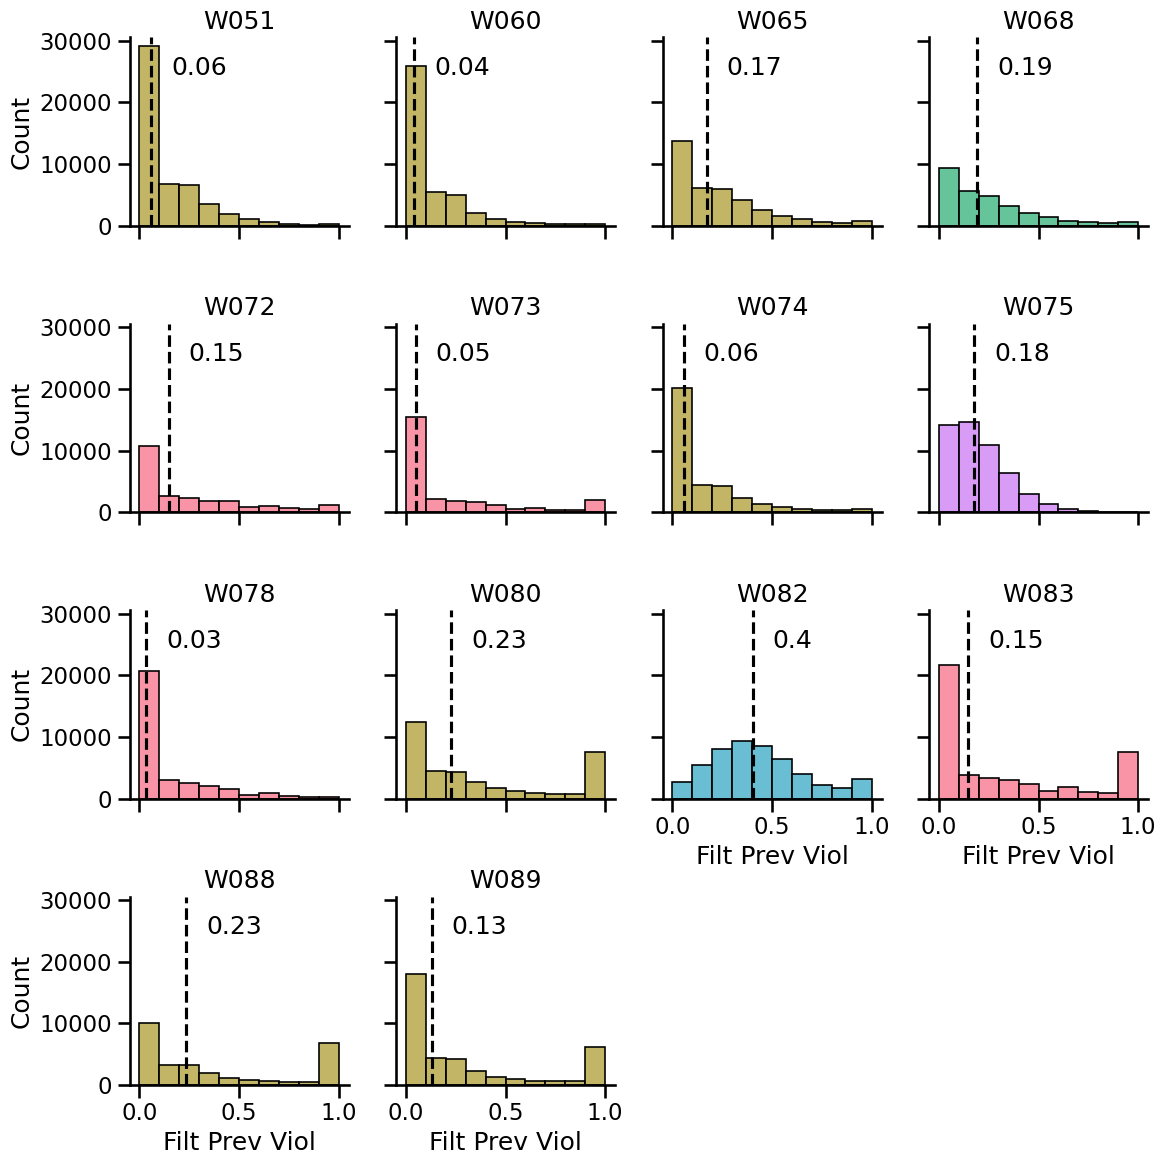

In [15]:
g = plot_histogram_facet_grid(
    prev_violation_df,
    "prev_violation_exp",
    binwidth=0.1,
    hue="prev_violation_tau",
    palette="husl",
)
g.map_dataframe(plot_prev_viol_median)
g.set_axis_labels("Filt Prev Viol", "Count")
g.set_titles("{col_name}")

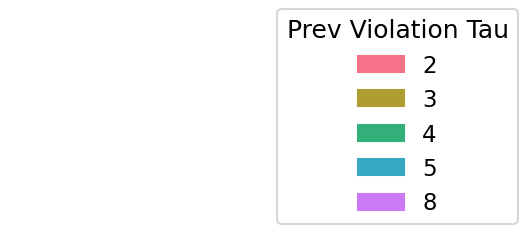

In [16]:
plot_prev_viol_tau_palette(min_stage=4)

## Part 2: Assess Distribution of Violation ITIs

The histograms below represent all trials. On hit trials, the iti is set to nan. On a violation trial, it the value is set to how many trials back the previous violation was. If it is 0, that means it immediately followed a violation. Greater than 0 means hits or errors occured between.

In [18]:
viol_iti_df = create_trials_df_w_viol_iti(animal_ids=stg4_animals, min_stage=4)

returning viol data for ['W051', 'W060', 'W065', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W082', 'W083', 'W088', 'W089']


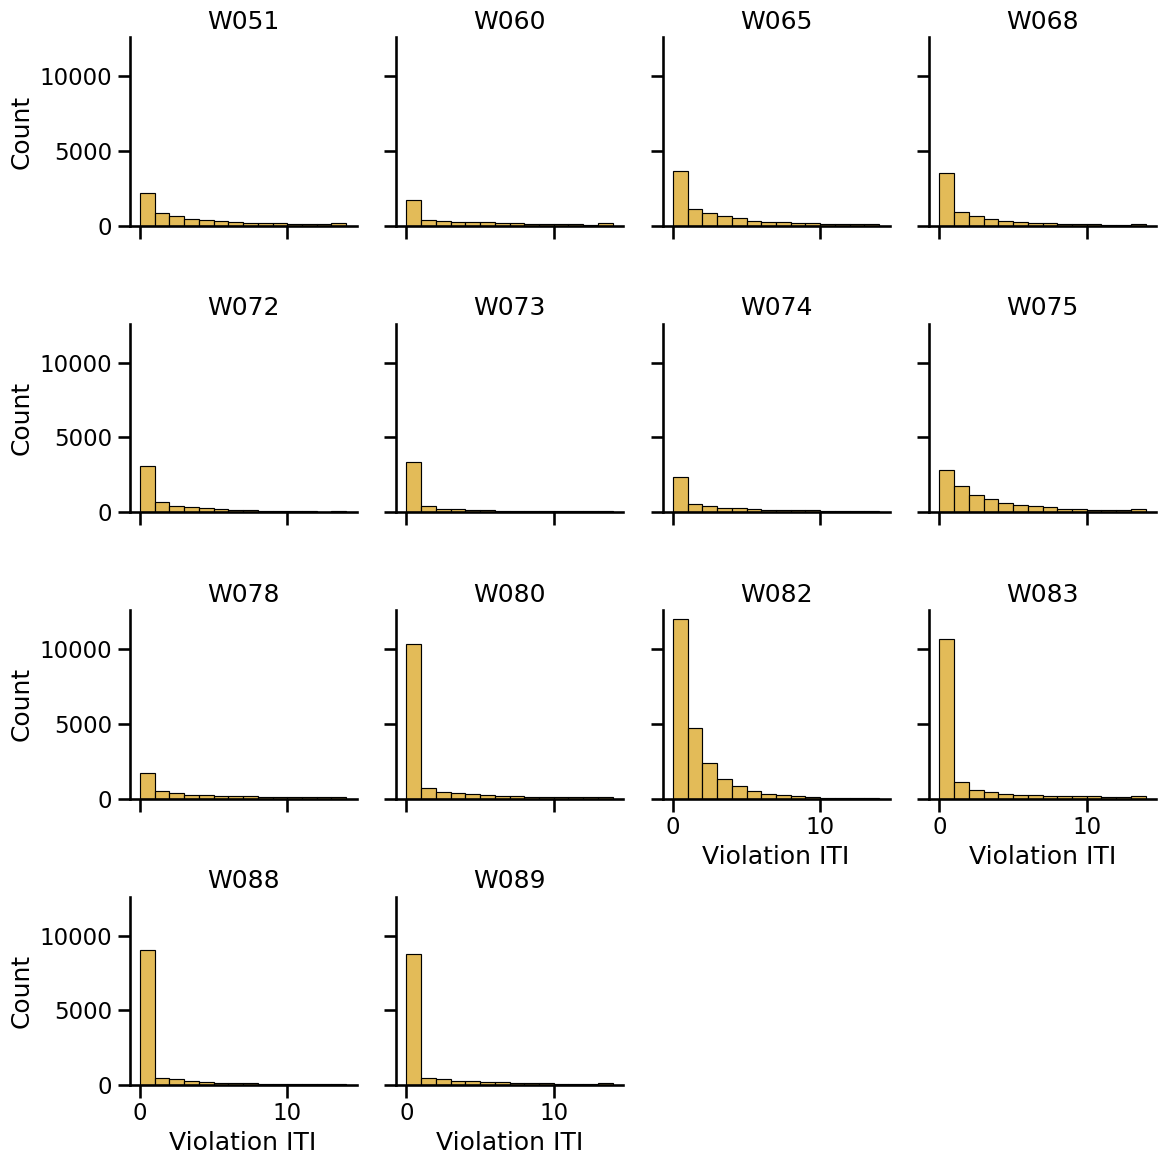

In [23]:
g = plot_histogram_facet_grid(
    viol_iti_df.query("violation_iti < 15"),
    "violation_iti",
    binwidth=1,
    color="goldenrod",
)
g.set_axis_labels("Violation ITI", "Count")
g.set_titles("{col_name}")

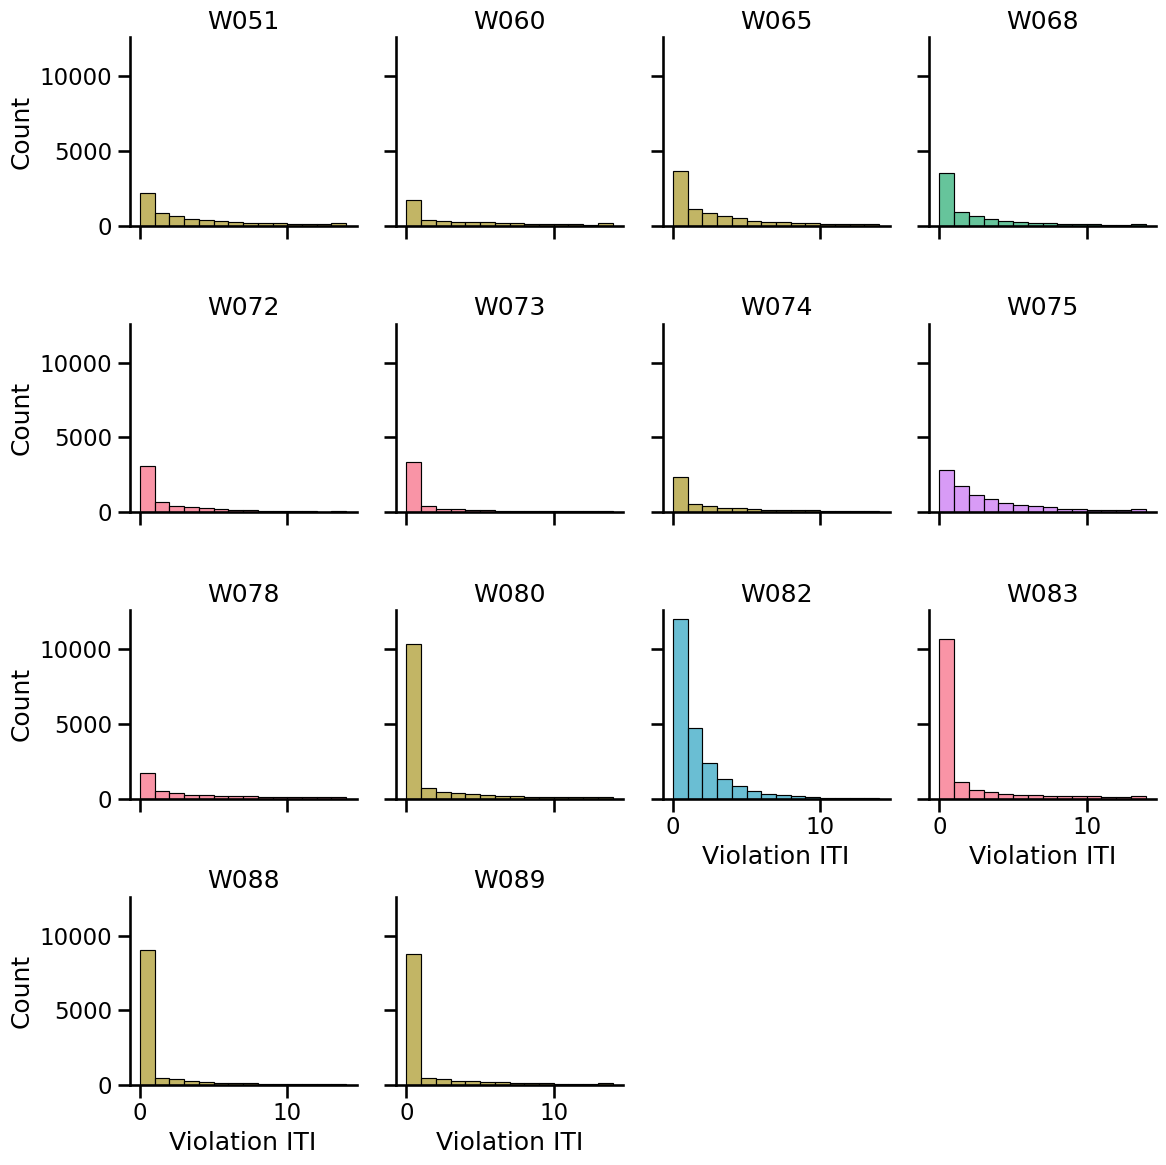

In [24]:
g = plot_histogram_facet_grid(
    viol_iti_df.query("violation_iti < 15"),
    "violation_iti",
    binwidth=1,
    hue="prev_violation_tau",
    palette="husl",
)
g.set_axis_labels("Violation ITI", "Count")
g.set_titles("{col_name}")

## Part 3: Assess Relationships between ITI, Violation Rates, Hit Rates and Tau

I am skipping these EDA visuals for now and just making the summary df needed for the psychometric.

In [61]:
create_frac_consecutive_viols_df(viol_iti_df)

,animal_id,frac_consecutive_viols
0,W051,0.298914
1,W060,0.329372
2,W065,0.406895
3,W068,0.462595
4,W072,0.493722
5,W073,0.588440
6,W074,0.409626
7,W075,0.278525
8,W078,0.354315
9,W080,0.737382


In [65]:
summary_viol_df = create_viol_features_summary_df(viol_iti_df, prev_violation_df)

f_name = "2024_01_19_stg4_summary_viol_df.csv"

summary_viol_df.to_csv(results_path + f_name, index=False)
summary_viol_df.head()

,animal_id,frac_consecutive_viols,median_prev_viol_exp,mean_prev_viol_exp,prev_violation_tau,quartile_25_prev_viol_exp,quartile_75_prev_viol_exp,session_avg_viol_rate,session_avg_hit_rate
0,W051,0.298914,0.057649,0.139170,3,0.002684,0.219698,0.170108,0.657759
1,W060,0.329372,0.040468,0.121645,3,0.002684,0.185149,0.158175,0.716869
2,W065,0.406895,0.171560,0.231017,3,0.042881,0.343169,0.245365,0.735580
3,W068,0.462595,0.190852,0.245831,4,0.065731,0.357563,0.299324,0.647584
4,W072,0.493722,0.145731,0.252727,2,0.011962,0.405724,0.308451,0.676600


## Part 5: Simulate Psychometrics

In [30]:
model_config = {
    "prev_violation_stim_intrx": {
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
    },
}

params = {
    "animals": stg4_animals,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "eval_train": True,
    "model_config": model_config,
    "tau_columns": ["prev_violation"],
    "min_training_stage": 4,
}

In [31]:
# # Commented out to freeze experiment and load from save in
# experiment = ExperimentSigmaSweep(params)
# experiment.run()
# experiment.save(file_name="2024_01_19_stg4_stim_violation_intrxs.pkl")

returning viol data for ['W051', 'W060', 'W065', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W082', 'W083', 'W088', 'W089']
minimum training stage is  4

 >>>> evaluating animal W051 <<<<

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.07 *****
Optimization terminated successfully.
         Current function value: 37311.461616
         Iterations: 31
         Function evaluations: 46
         Gradient evaluations: 46

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 36986.153307
         Iterations: 29
         Function evaluations: 41
         Gradient evaluations: 41

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.25 *****
         Current function value: 36844.121486
         Iterations: 30
         Function evaluations: 107
         Gradient evaluations: 96

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.5 *****
Optimization terminated s

In [64]:
import pickle

experiment_fname = "2024_01_19_stg4_stim_violation_intrxs.pkl"

with open(results_path + experiment_fname, "rb") as f:
    experiment = pickle.load(f)

mv = ModelVisualizer(experiment)

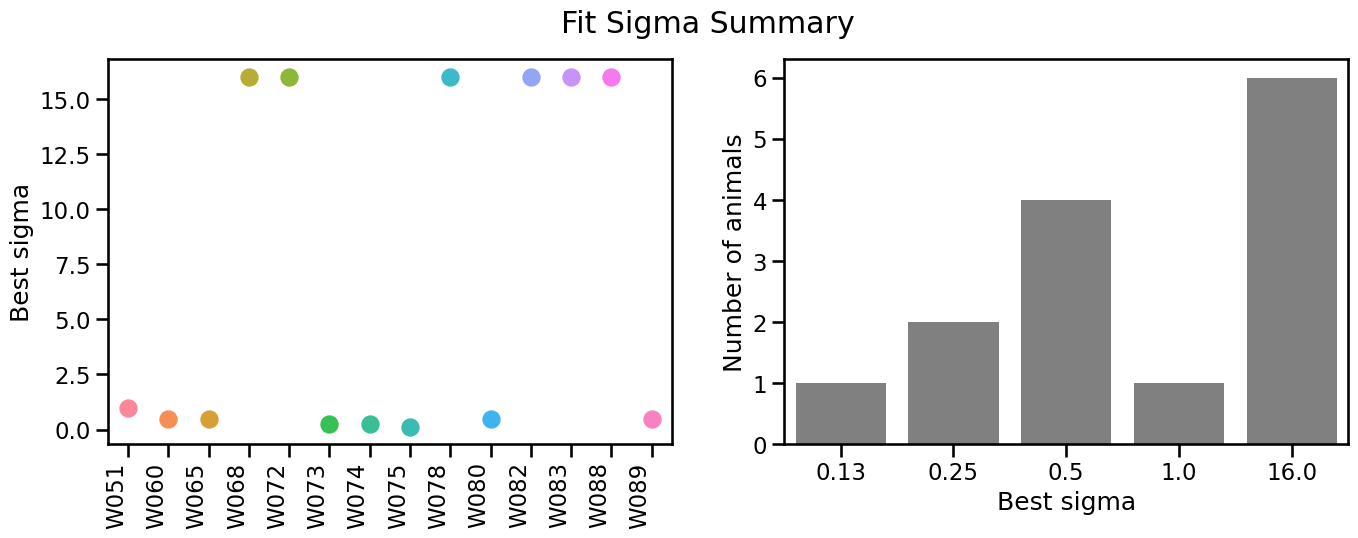

In [33]:
mv.plot_sigma_summary()

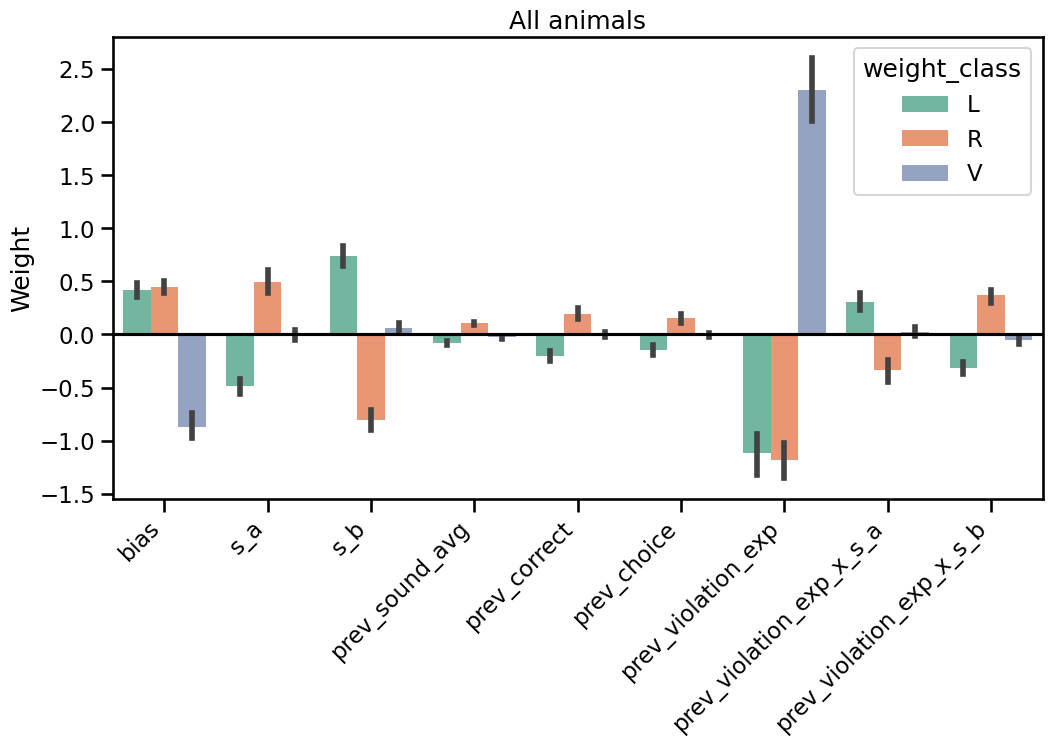

In [34]:
mv.plot_weights_summary(palette="Set2")

In [39]:
features_of_interest = [
    "bias",
    "s_a",
    "s_b",
    "prev_violation_exp_x_s_a",
    "prev_violation_exp_x_s_b",
]
weight_class_of_interest = ["L", "R"]

flattened_df = mv.unpack_features_and_weights(mv.find_best_fit())

flattened_df = flattened_df.query(
    "feature in @features_of_interest and weight_class in @weight_class_of_interest"
).copy()

delta_weights_df = pd.DataFrame(
    columns=["animal_id", "feature", "weight", "weight_class"]
)
for (aid, feature), sub_df in flattened_df.groupby(["animal_id", "feature"]):
    L_weights = sub_df.query("weight_class == 'L'").weight.values[0]
    R_weights = sub_df.query("weight_class == 'R'").weight.values[0]
    weight_diff = R_weights - L_weights

    data = {
        "animal_id": aid,
        "feature": feature,
        "weight": weight_diff,
        "weight_class": "R-L",
    }
    idx = len(delta_weights_df)
    for key, value in data.items():
        delta_weights_df.loc[idx, key] = value

delta_weights_df.head()

,animal_id,feature,weight,weight_class
0,W051,bias,0.044349,R-L
1,W051,prev_violation_exp_x_s_a,-0.919117,R-L
2,W051,prev_violation_exp_x_s_b,0.938343,R-L
3,W051,s_a,0.939017,R-L
4,W051,s_b,-1.154528,R-L


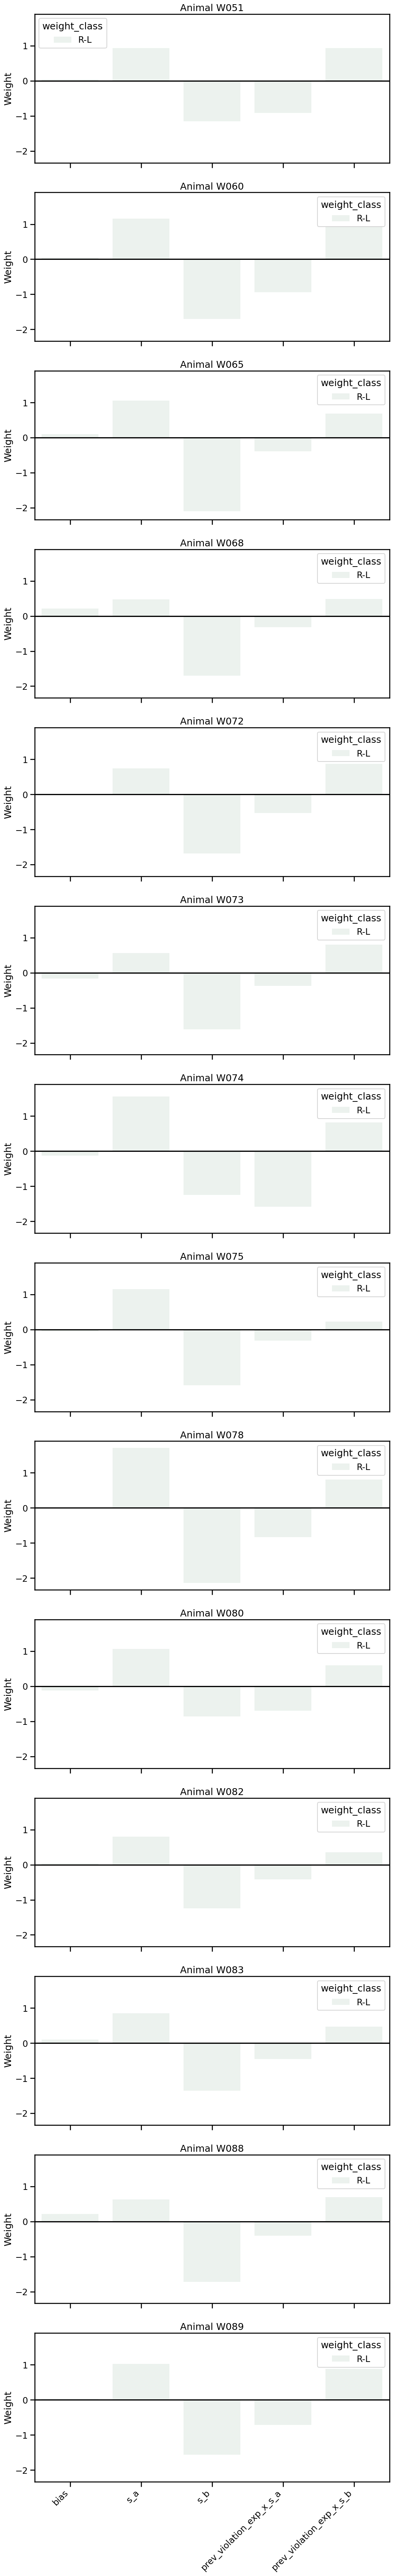

In [40]:
mv.plot_weights_by_animal(
    delta_weights_df, order=features_of_interest, color="mediumseagreen"
)

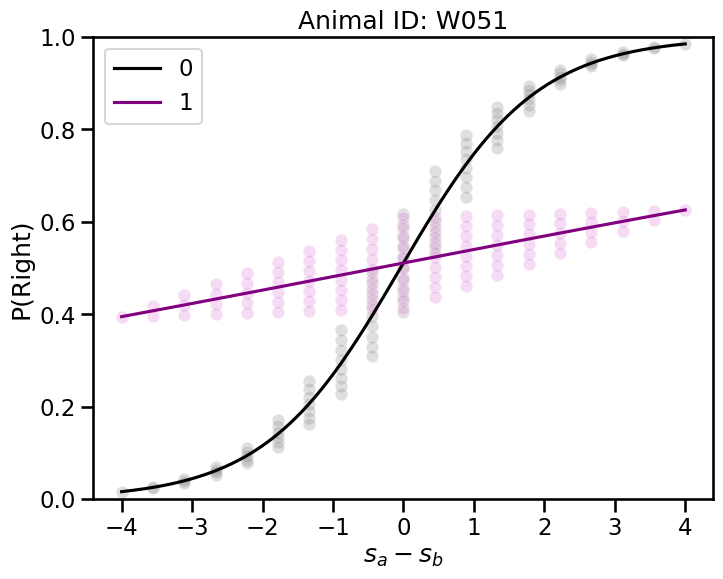

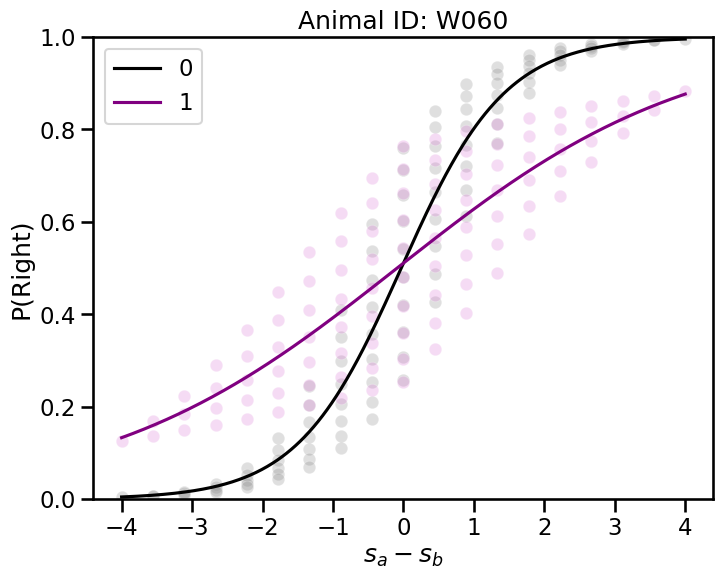

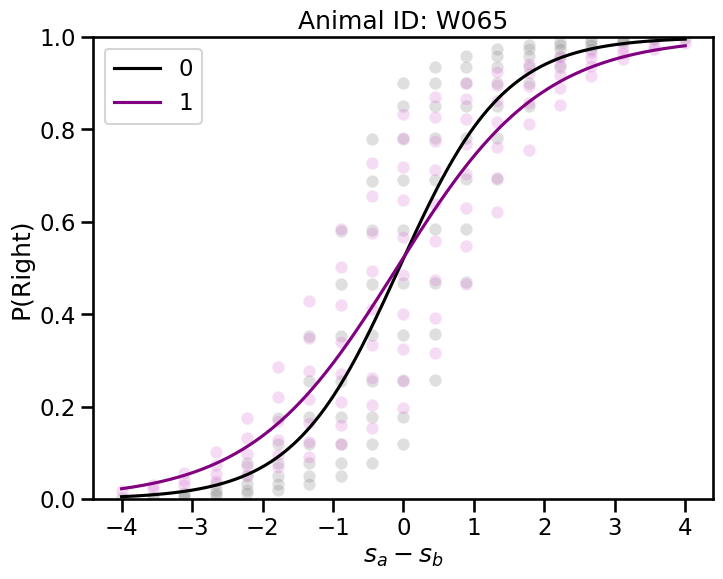

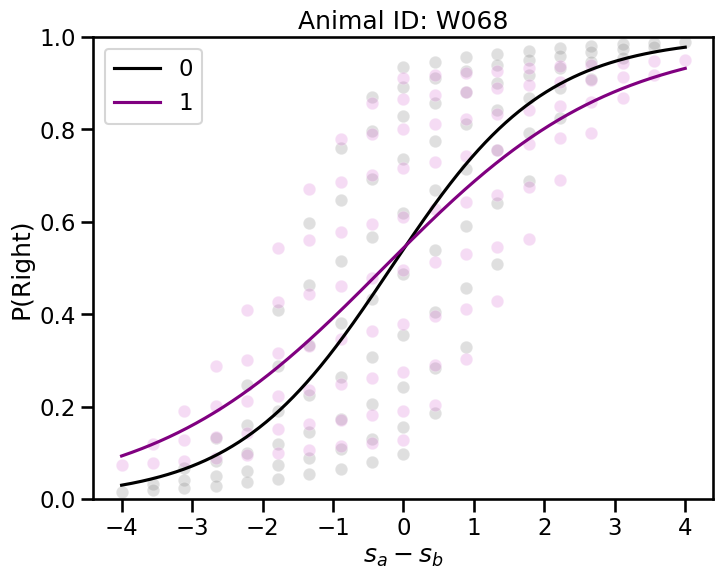

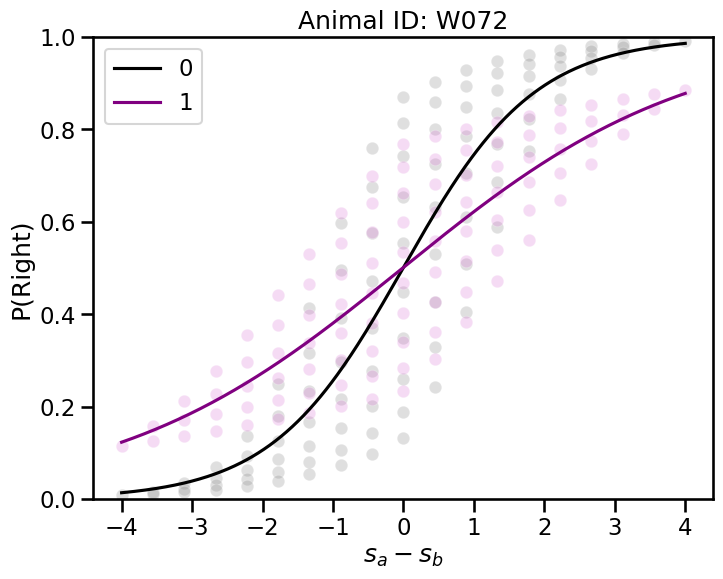

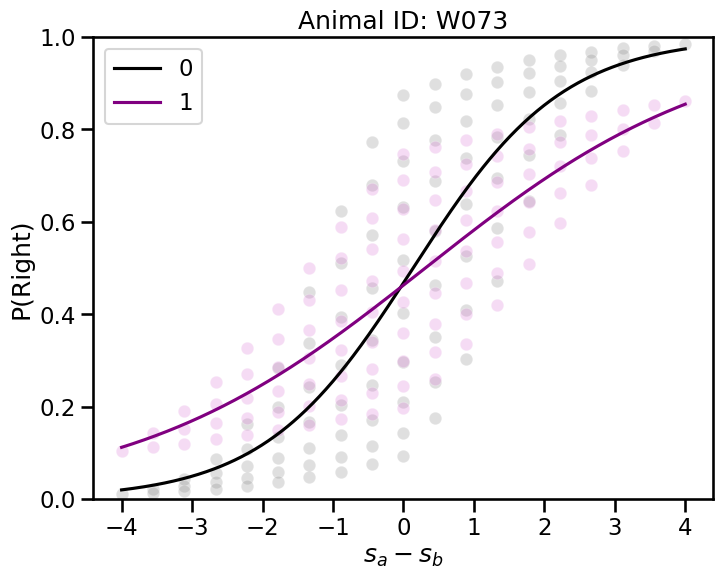

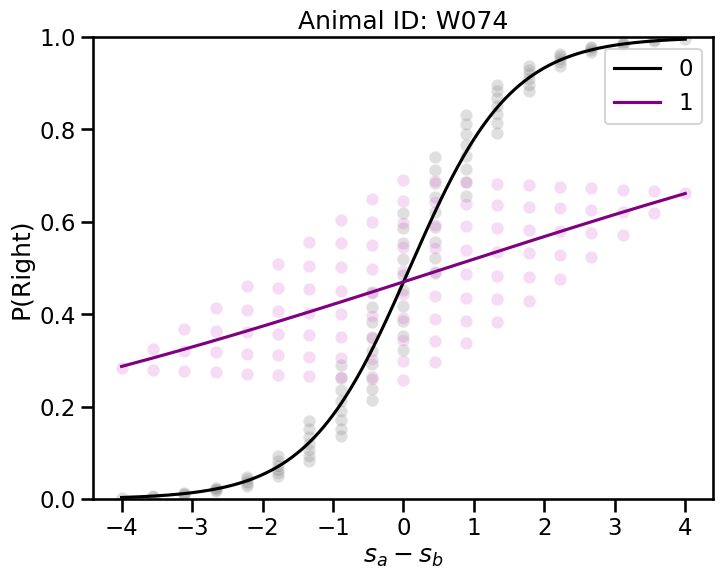

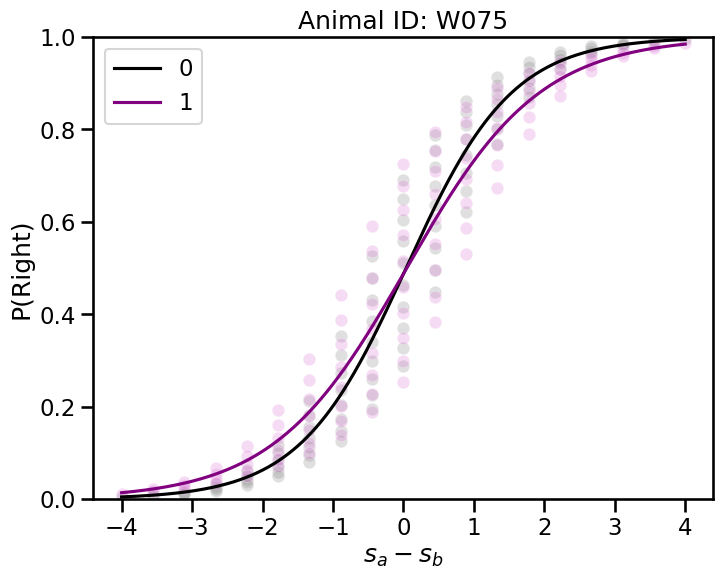

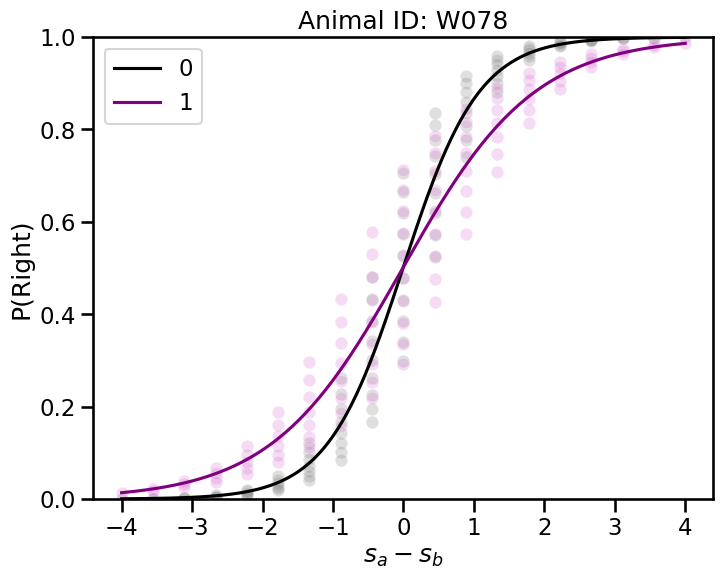

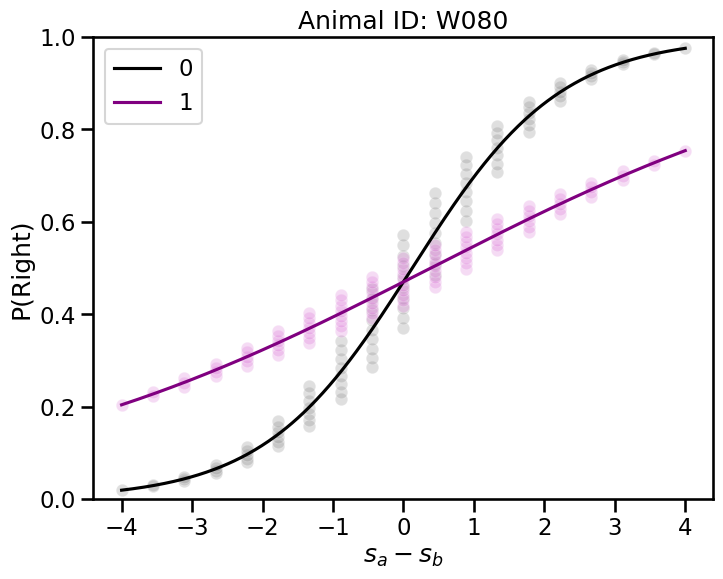

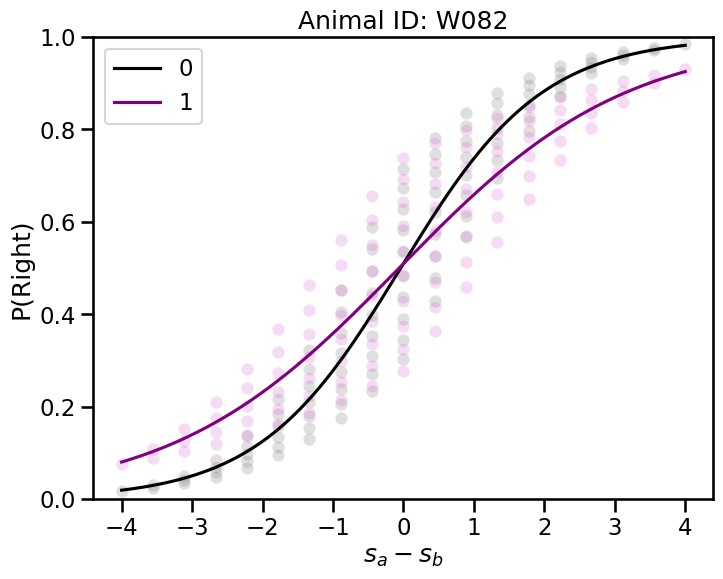

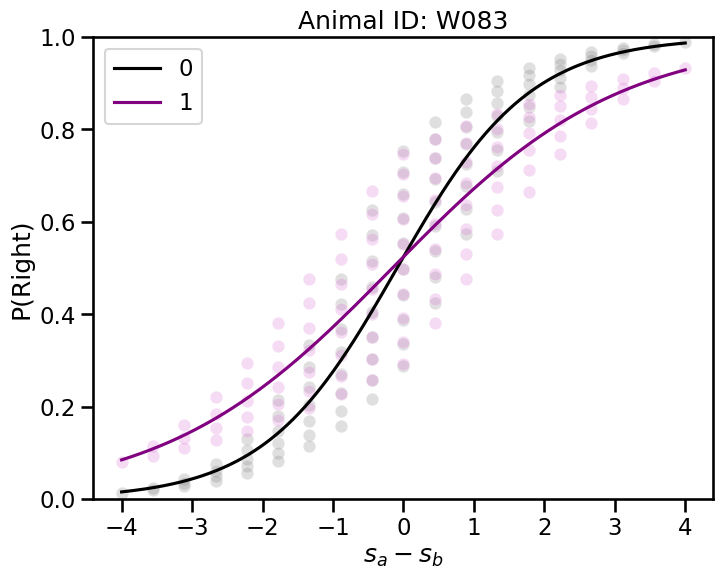

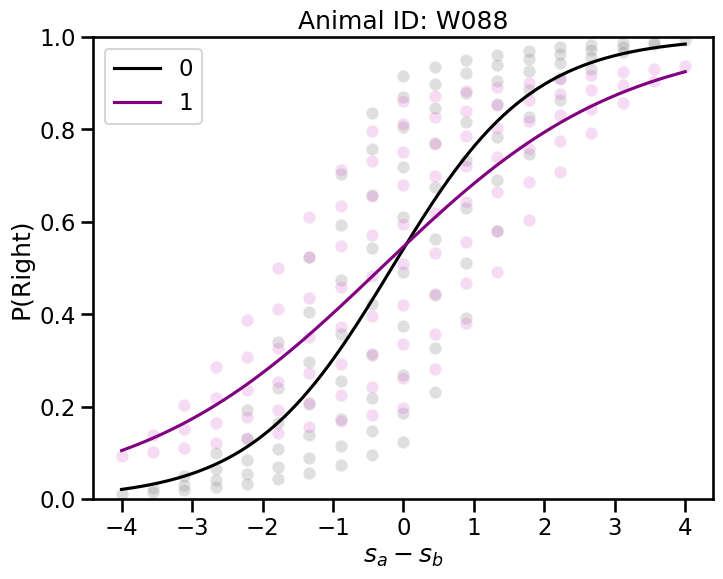

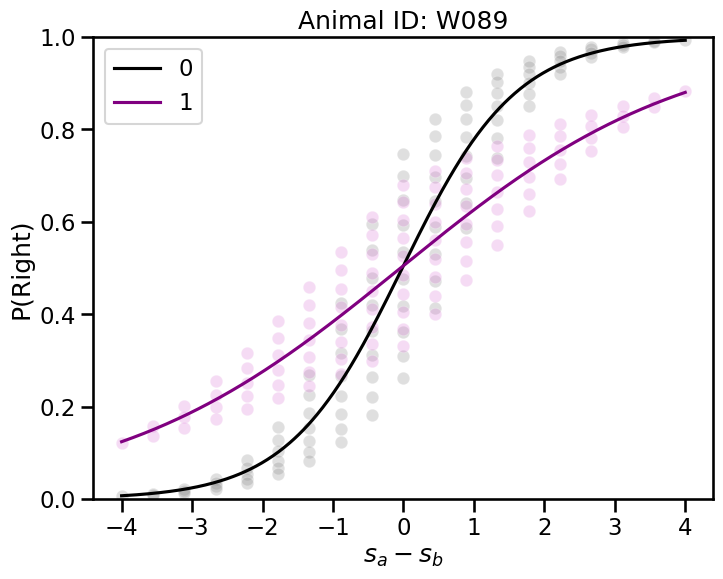

In [56]:
from psychometrics import *

X_enhanced = generate_x_data()
# List to collect fit results
fit_results = []
psych_results = []

# Loop over each unique animal

for animal_id in delta_weights_df["animal_id"].unique():
    sub_df = delta_weights_df.query(f"animal_id == '{animal_id}'")

    fig, ax = plt.subplots(figsize=(8, 6))

    for filter_val in [0, 1]:
        # Simulate the psychometric data
        deltax, ys = simulate_psych(sub_df, X_enhanced, filter_val)

        # Fit the psychometric function
        params, covariance = fit_psych(deltax, ys)

        # Collect the results
        fit_results.append(
            {
                "animal_id": animal_id,
                "filter": "on" if filter_val else "off",
                "alpha": params[0],
                "beta": params[1],
            }
        )

        # Plot the results
        sns.scatterplot(
            x=deltax,
            y=ys,
            ax=ax,
            alpha=0.25,
            color="orchid" if filter_val else "gray",
        )
        x_vals = np.linspace(deltax.min(), deltax.max(), 500)
        fitted_ys = sigmoid_for_curve_fit(x_vals, *params)

        psych_results.extend(
            {
                "animal_id": animal_id,
                "delta_stim": x_val,
                "p_right": y_val,
                "filter_val": filter_val,
            }
            for x_val, y_val in zip(x_vals, fitted_ys)
        )
        sns.lineplot(
            x=x_vals,
            y=fitted_ys,
            ax=ax,
            label=filter_val,
            color="purple" if filter_val else "black",
        )

    ax.set_title(f"Animal ID: {animal_id}")
    ax.set_xlabel("$s_a - s_b$")
    ax.set_ylabel("P(Right)")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

# Create a DataFrame from the collected fit results
fit_results_df = pd.DataFrame(fit_results)
psych_results_df = pd.DataFrame(psych_results)

# Optional: Save fit results to a file
# fit_results_df.to_csv('fit_results.csv', index=False)

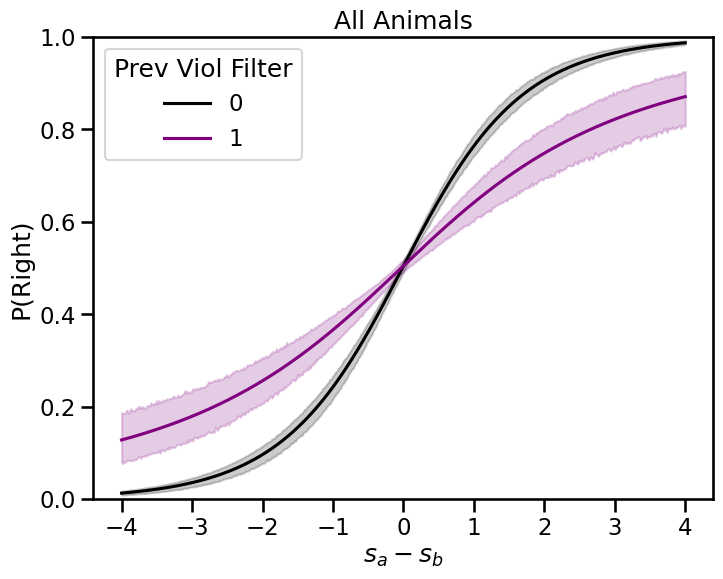

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=psych_results_df,
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_val",
    hue_order=[0, 1],
    palette=["black", "purple"],
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()

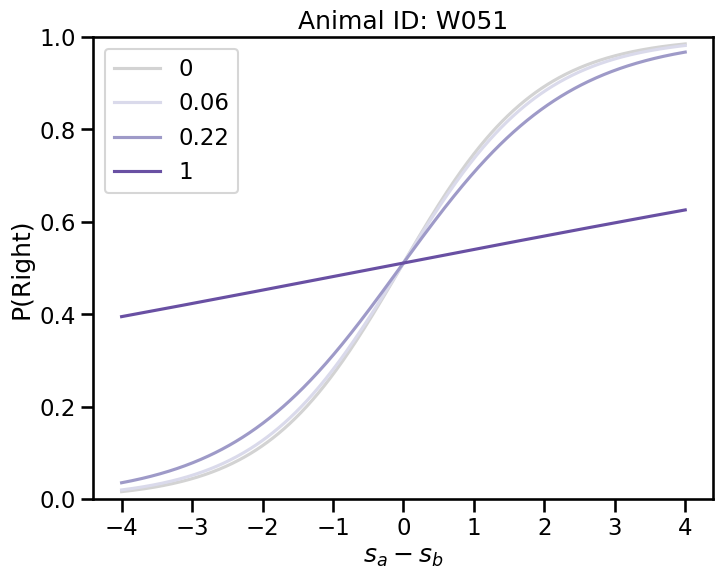

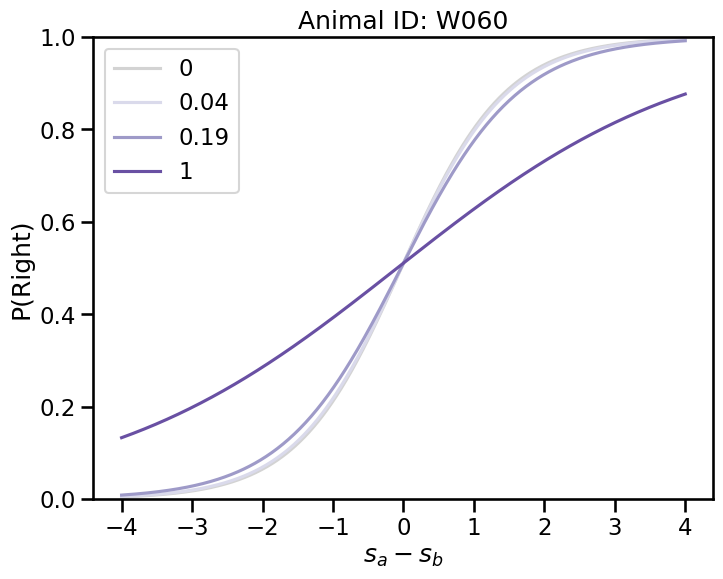

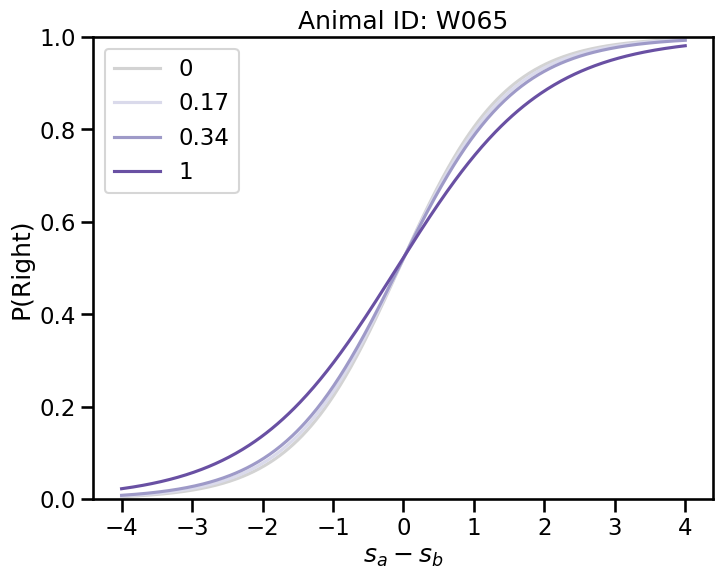

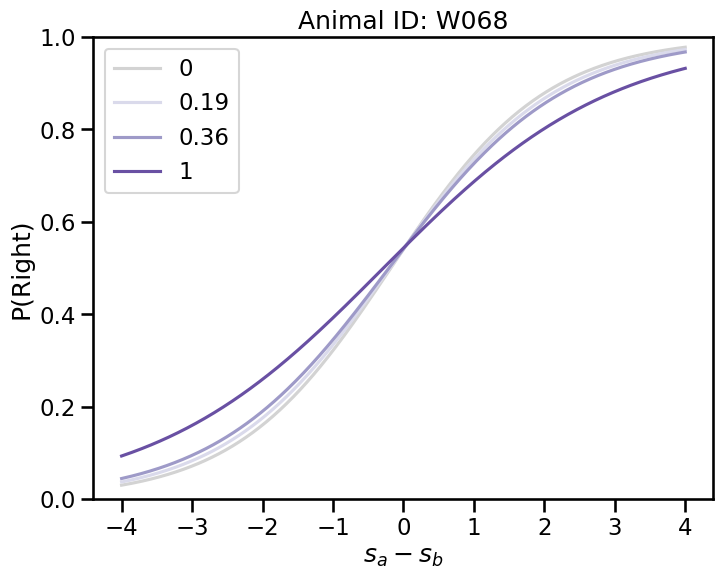

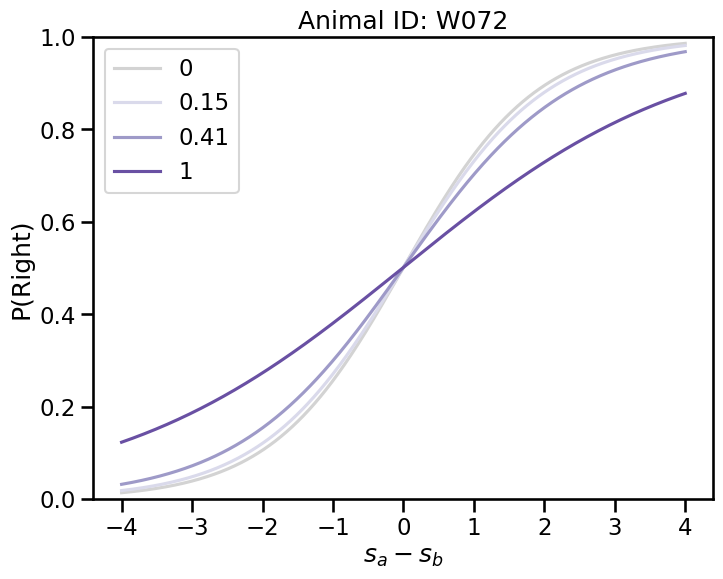

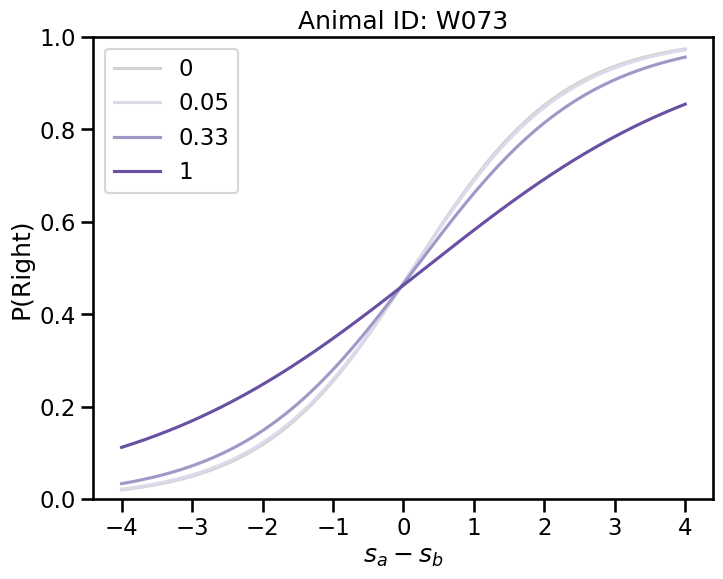

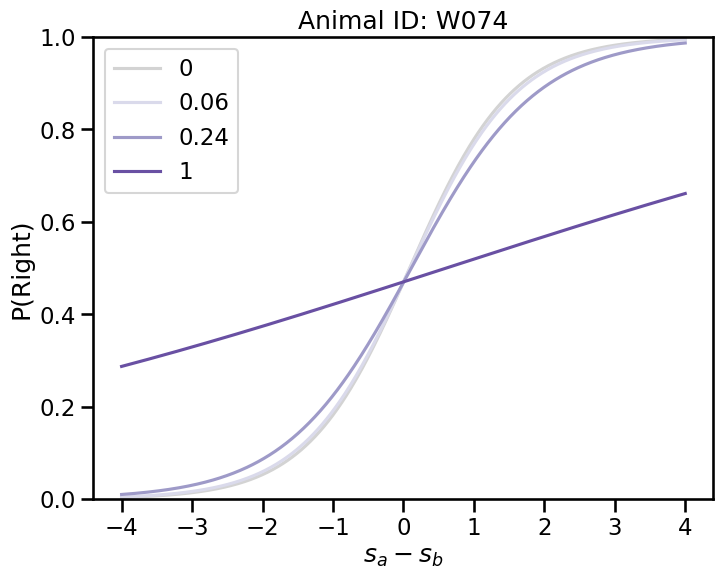

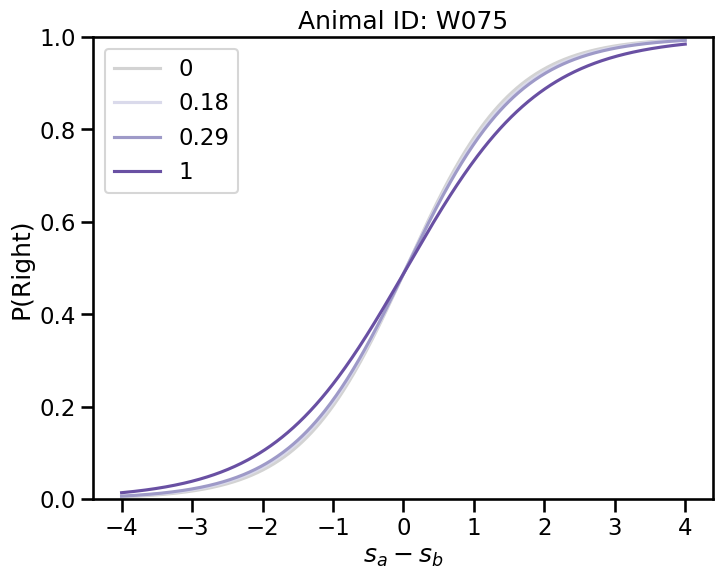

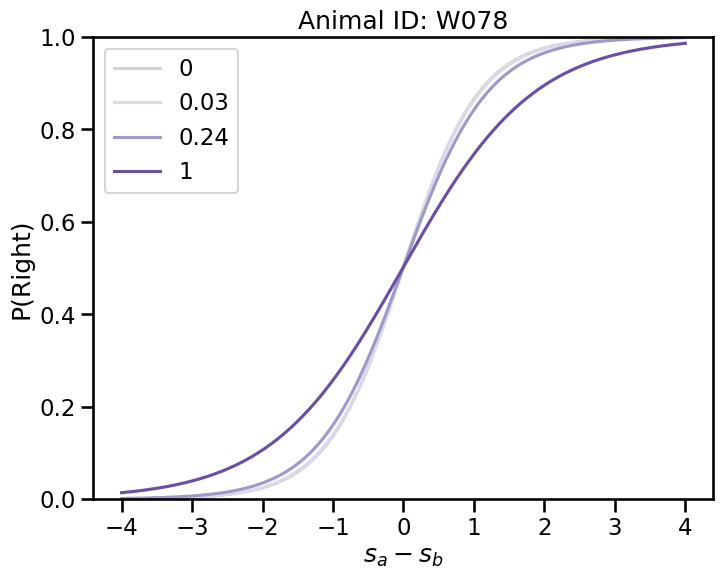

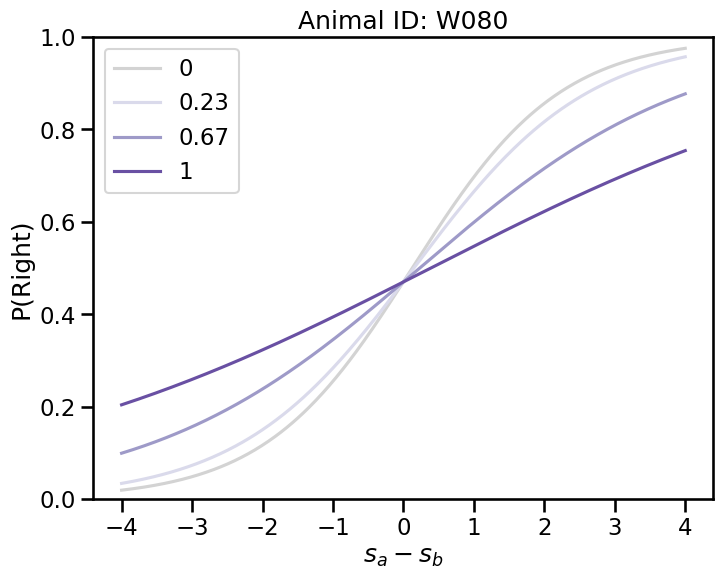

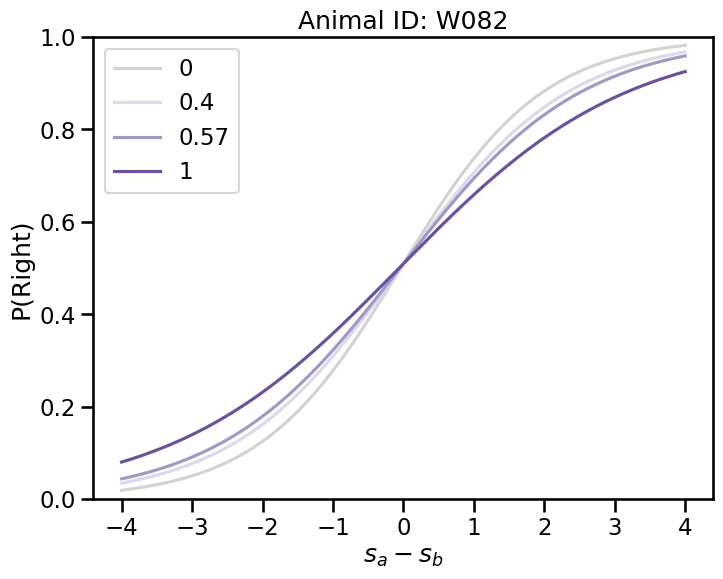

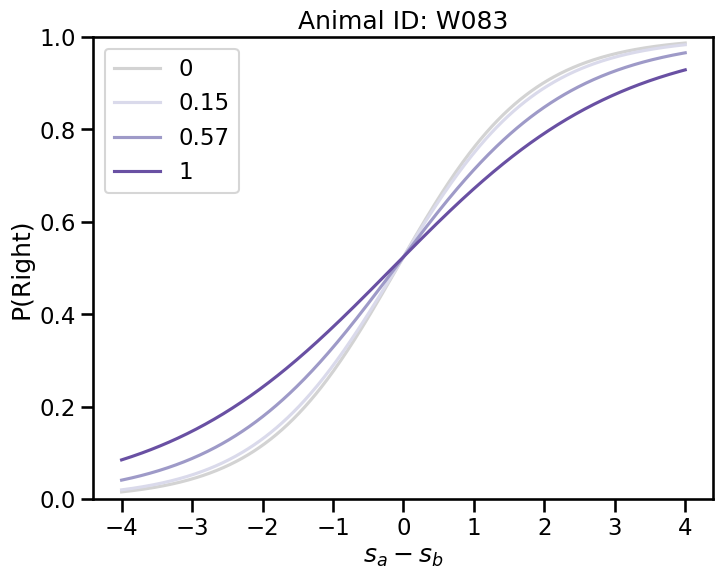

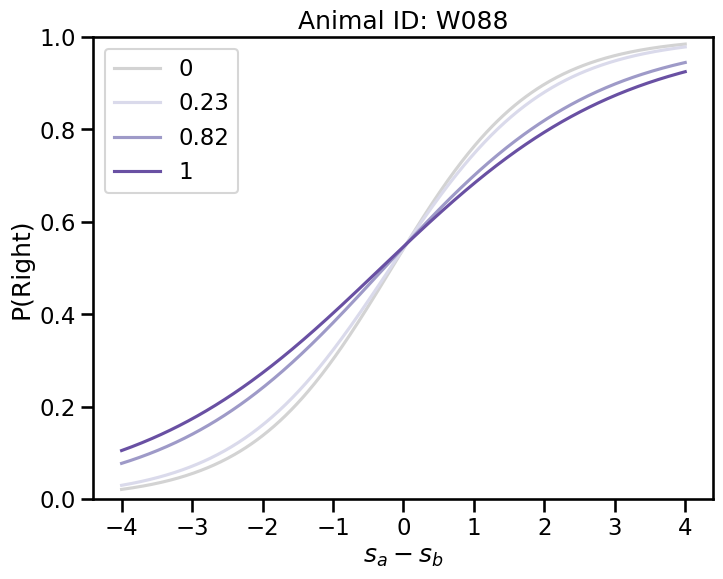

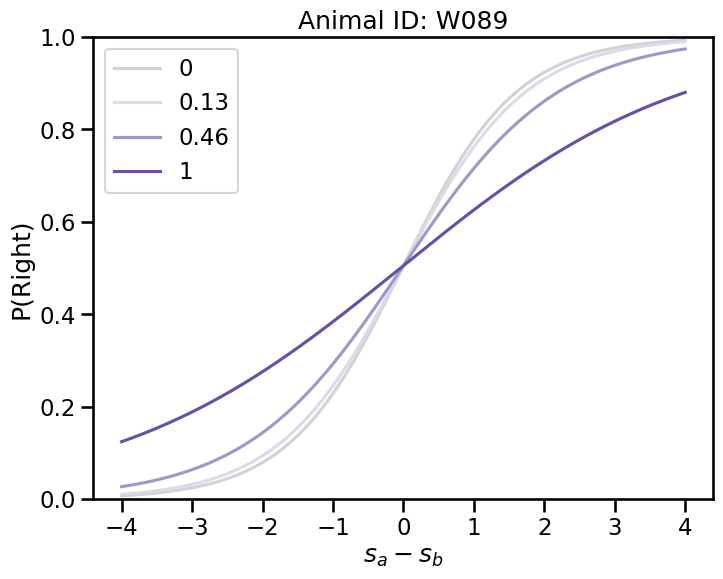

In [58]:
# List to collect fit results
full_fit_results = []
full_psych_results = []
summary_viol_df = pd.read_csv(results_path + "2024_01_19_stg4_summary_viol_df.csv")
psych_pallette = ["lightgray"] + [x for x in sns.color_palette("Purples", 3)]
filter_type = ["min (0)", "median", "75%", "max (1)"]
# Loop over each unique animal

for animal_id in delta_weights_df["animal_id"].unique():
    sub_df = delta_weights_df.query(f"animal_id == '{animal_id}'")

    meidan_filter_val = summary_viol_df.query("animal_id == @animal_id")[
        "median_prev_viol_exp"
    ].values[0]

    quartile_75_filter_val = summary_viol_df.query("animal_id == @animal_id")[
        "quartile_75_prev_viol_exp"
    ].values[0]

    fig, ax = plt.subplots(figsize=(8, 6))

    for idx, filter_val in enumerate([0, meidan_filter_val, quartile_75_filter_val, 1]):
        # Simulate the psychometric data
        deltax, ys = simulate_psych(sub_df, X_enhanced, filter_val)

        # Fit the psychometric function
        params, covariance = fit_psych(deltax, ys)

        # Collect the results
        full_fit_results.append(
            {
                "animal_id": animal_id,
                "filter": filter_val,
                "alpha": params[0],
                "beta": params[1],
            }
        )

        x_vals = np.linspace(deltax.min(), deltax.max(), 500)
        fitted_ys = sigmoid_for_curve_fit(x_vals, *params)

        full_psych_results.extend(
            {
                "animal_id": animal_id,
                "delta_stim": x_val,
                "p_right": y_val,
                "filter_val": filter_val,
                "filter_type": filter_type[idx],
            }
            for x_val, y_val in zip(x_vals, fitted_ys)
        )
        sns.lineplot(
            x=x_vals,
            y=fitted_ys,
            ax=ax,
            label=np.round(filter_val, 2),
            color=psych_pallette[idx],
        )

    ax.set_title(f"Animal ID: {animal_id}")
    ax.set_xlabel("$s_a - s_b$")
    ax.set_ylabel("P(Right)")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

# Create a DataFrame from the collected fit results
full_fit_results_df = pd.DataFrame(full_fit_results)
full_psych_results_df = pd.DataFrame(full_psych_results)

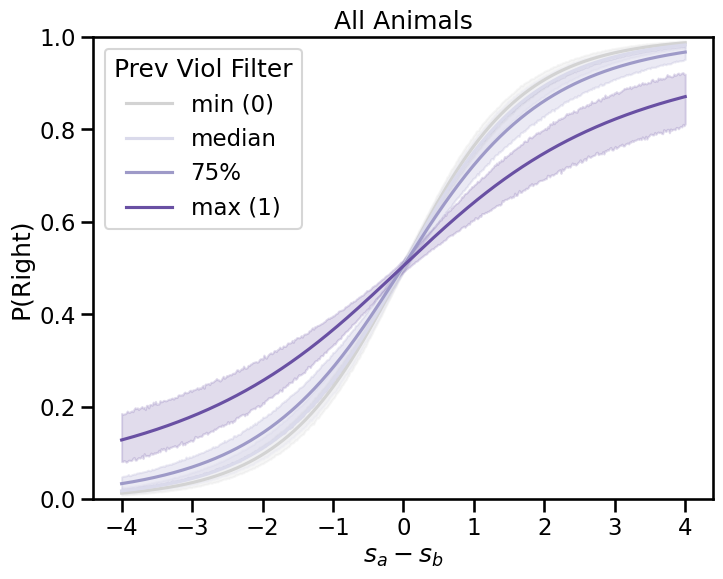

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=full_psych_results_df,
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_type",
    hue_order=filter_type,
    palette=psych_pallette,
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()

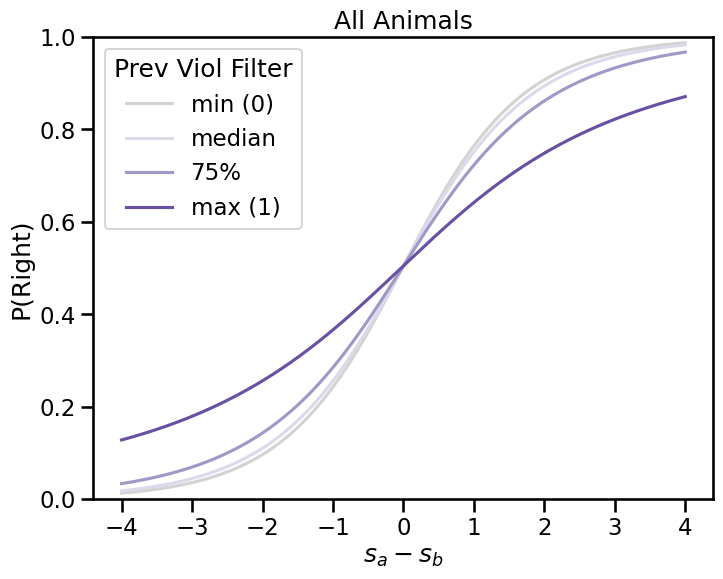

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=full_psych_results_df,
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_type",
    hue_order=filter_type,
    palette=psych_pallette,
    errorbar=None,
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()

**Summary**: There still appears to be a graded effect of previous violation history on the psychometric function. With this subsetted dataset, the effect appears to be slightly smaller, but still event much present. It would be interesting to fit animals in stage 4 pre first crossing ("learning") and then fit animals in stage 4 post last crossing ("learned") and see how the effect changes. It would be interested to know if the effect of violations (or even the distribution of them) changes during learning versus final performance. 